# Practicing loss functions and regression metrics

Below you will practice looking at loss functions and look at regression metrics related to these loss functions.

---

## 1. Load packages

In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

---

## 2. Plotting functions

Here are the functions from the presentation to make visualizing your regressions easier:

In [8]:
def plot_regression(x, y, model):
    plt.figure(figsize=(10,8))
    axes = plt.gca()
    
    intercept = model.params[0]
    slope = model.params[1]

    for x_, y_ in zip(x, y):    
        plt.plot((x_, x_), (y_, x_*slope + intercept),
                 'k-', ls='dashed', lw=1)
        
    plt.scatter(x, y, s=70, c='steelblue')
    
    x_points = np.linspace(axes.get_xlim()[0], axes.get_xlim()[1], 100)
    
    regline_x = x_points
    regline_y = x_points*slope + intercept

    plt.plot(regline_x, regline_y, c='darkred', lw=3.5)

    plt.show()
    
    
def plot_leastsq_loss(model):
    plt.figure(figsize=(10,8))
    
    resids = model.resid
    
    resid_lim = np.max([abs(np.min(resids)), abs(np.max(resids))]) + 1
    
    resid_points = np.linspace(-1*resid_lim, resid_lim, 200)
    
    for r in resids:
        plt.plot((r, r), (0, r**2), 'k-', ls='dashed', lw=2)
        
    plt.plot(resid_points, resid_points**2, c='gold', alpha=0.7)
    

def plot_residuals_ladloss(model):
    
    resids = model.resid
    
    resid_lim = np.max([abs(np.min(resids)), abs(np.max(resids))]) + 1
    
    resid_points = np.linspace(-1*resid_lim, resid_lim, 200)
    
    plt.figure(figsize=(10,8))
    
    for r in resids:
        
        plt.plot((r, r), (0, abs(r)), 'k-', ls='dashed', lw=1)
        
    plt.plot(resid_points, np.abs(resid_points), c='gold', alpha=0.7)
    


---

## 3. Load in the data from project 3

Load your data from project 3. Below is the small version I put in datasets, but if you've worked on it and have it cleaned you may want to load your version instead.

In [9]:
# here is the small version i put in your datasets folder:
iowa_file = '/Users/tlee010/desktop/DSI-SF-2-timdavidlee/datasets/Iowa/Iowa_Liquor_sales_reduced.csv'
iowa = pd.read_csv(iowa_file)
print len(iowa)

2709552


In [24]:
sample_row_nos = np.random.randint(0, len(iowa), size= 28000)
idf = iowa.iloc[sample_row_nos,:] 

---

## 4. Choose a continuous response variable and predictor variable from the dataset

If you choose columns with dollar amounts, you will need to remove the dollar signs!

In [25]:
print idf.info()
# bottle cost vs. sales


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28000 entries, 323466 to 1407934
Data columns (total 18 columns):
Date                     28000 non-null object
Store Number             28000 non-null int64
City                     28000 non-null object
Zip Code                 28000 non-null object
County Number            27893 non-null float64
County                   27893 non-null object
Category                 27990 non-null float64
Category Name            27929 non-null object
Vendor Number            28000 non-null int64
Item Number              28000 non-null int64
Item Description         28000 non-null object
Bottle Volume (ml)       28000 non-null int64
State Bottle Cost        28000 non-null object
State Bottle Retail      28000 non-null object
Bottles Sold             28000 non-null int64
Sale (Dollars)           28000 non-null object
Volume Sold (Liters)     28000 non-null float64
Volume Sold (Gallons)    28000 non-null float64
dtypes: float64(4), int64(5), object(9)

In [28]:
#clean the data

def clean_dollars(x):
    x['clean_bottle_cost'] = float(x['State Bottle Cost'].replace('$',''))
    x['total_sales'] = float(x['Sale (Dollars)'].replace('$',''))
    return x

idf = idf.apply(clean_dollars, axis = 1)
idf.head(2)


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),clean_bottle_cost,total_sales
323466,02/08/2016,4829,DES MOINES,50314,77.0,Polk,1062100.0,JAMAICA RUM,260,42167,Myers's Rum Original Dark,1000,$12.50,$18.75,12,$225.00,12.00,3.17,12.50,225.00
2082596,04/22/2015,2566,KNOXVILLE,50138,63.0,Marion,1011200.0,STRAIGHT BOURBON WHISKIES,461,22155,Wild Turkey 101 Round,375,$6.25,$9.38,2,$18.76,0.75,0.20,6.25,18.76
314629,02/08/2016,4970,WEST LIBERTY,52776,70.0,Muscatine,1011100.0,BLENDED WHISKIES,260,25608,Seagrams 7 Crown Bl Whiskey,1750,$11.96,$17.94,6,$107.64,10.50,2.77,11.96,107.64
2043494,04/29/2015,2566,KNOXVILLE,50138,63.0,Marion,1031080.0,VODKA 80 PROOF,205,36969,New Amsterdam Vodka,750,$6.90,$10.35,12,$124.20,9.00,2.38,6.90,124.20
170940,03/03/2016,2627,DES MOINES,50310,77.0,Polk,1012200.0,SCOTCH WHISKIES,260,5326,Johnnie Walker Black,750,$20.99,$31.49,4,$125.96,3.00,0.79,20.99,125.96


In [94]:
predictor = 'Bottles Sold'
target ='total_sales'

model_data = idf[[predictor,target]]
model_data.reset_index(inplace = True)
model_data.sort_values(predictor, ascending = False)
#model_data_clean = model_data.drop(840, axis = 0)

#print model_data['clean_bottle_cost'].value_counts()
#model_data[model_data['clean_bottle_cost']==5800.00]

,index,Bottles Sold,total_sales
4418,2302287,660,4250.40
8303,1988413,660,4250.40
1786,323950,660,6850.80
2338,1036617,588,8631.84
20056,1694436,564,10569.36
3922,607576,540,6755.40
449,738235,480,8582.40
18338,60209,480,643.20
16316,313991,372,4002.72
16087,1765783,372,2232.00


---

## 5. Choose a small subset of the predictor and response variables you chose

You can use the ```np.random.choice()``` function to get a random sample of indices. Look up how to use it!

In [95]:
pick_indices = np.random.choice(range(len(model_data)-1), size =5000 )
subset = model_data.iloc[pick_indices,:]
print len(subset)
print subset.head()

5000
         index  Bottles Sold  total_sales
26215  1640545             3        35.10
1169    936853             3        60.75
11715  1538264            12        78.12
26683  1366794             6        68.40
3631    501806            12       123.24


---

## 6. Build a least squares regression model predicting your response from your predictors

For this one use statsmodels rather than sklearn.

I did not provide the code to create the regression. Either look it up in the statsmodels documentation or refer to the slides so you can practice doing this yourself.

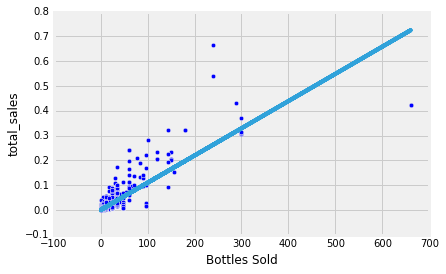

In [98]:
import statsmodels.api as sm



X = subset[predictor]
y = subset[target]/10000

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

plt.scatter(X,y)
plt.plot(X,predictions)



# # Plot the model
# plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel(predictor)
plt.ylabel(target)
# plt.show()

# print "MSE:", mean_squared_error(y, predictions)

---

## 7. Plot the least squares regression

You can use the ```plot_regression(x, y, model)``` function provided.

0.0010983241163389848

---

## 8. Build a least absolute deviation quantreg model on the same sample

---

## 9. Plot the LAD regression

---

## 10. Calculate the RMSE and the MAE between you response and predicted response

**RMSE** is the **root mean squared error**. It is a metric for the performance of your regression related to the least squared loss. 

$$\text{RMSE} = \sqrt{\frac{\sum_{i}{\left(\hat{y}_i - y_i \right)^2}}{n}}$$

https://en.wikipedia.org/wiki/Root-mean-square_deviation

**MAE** is the **mean absolute error**. It is a metric for regression performace when the loss function is the least absolute deviation.

$$\text{MAE} = \frac{\sum_{i}{|\hat{y}_i - y_i |}}{n}$$

https://en.wikipedia.org/wiki/Average_absolute_deviation

In [4]:
## RMSE:

In [5]:
## MAE:

---

## 11. [Challenge] What would be the loss function to find the _mode_ and why?

Remember that the least squares loss minimizes:

### $$\sum_{i}{\left(\hat{y}_i - y_i \right)^2}$$

And the least absolute deviation loss minimizes:

### $$y = \sum_{i}{|\hat{y}_i - y_i |^1}$$

**Do you see a pattern here?**


In [6]:
#

---

## 12. Create a quantile regression with q = 0.25 and plot it. What exactly is this regression predicting?